## Scaling modeling
- Z - Score
- Min - Max Scaling
- Log Scaling
    - Apply train, val, test

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [144]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


## Base

In [145]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [146]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [147]:
"""to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']

scaler = MinMaxScaler()
data_x_scaled = data_x.copy()
data_x_scaled[to_scale] = scaler.fit_transform(data_x_scaled[to_scale])

X_test[to_scale] = scaler.transform(X_test[to_scale])"""

"to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']\n\nscaler = MinMaxScaler()\ndata_x_scaled = data_x.copy()\ndata_x_scaled[to_scale] = scaler.fit_transform(data_x_scaled[to_scale])\n\nX_test[to_scale] = scaler.transform(X_test[to_scale])"

In [148]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
data_x_scaled = data_x.copy()

for col in to_scale:
    data_x_scaled[col] = np.log1p(data_x_scaled[col])  # log(1 + x) → 0 값 대응
    X_test[col] = np.log1p(X_test[col])

In [149]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.13, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1295091 samples (87.0%)
Validation size: 193520 samples (13.0%)
Test size: 372153 samples (25.0%)


In [150]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.49200	validation_1-logloss:0.49202
[1]	validation_0-logloss:0.48744	validation_1-logloss:0.48749
[2]	validation_0-logloss:0.48300	validation_1-logloss:0.48307
[3]	validation_0-logloss:0.47868	validation_1-logloss:0.47877
[4]	validation_0-logloss:0.47447	validation_1-logloss:0.47459
[5]	validation_0-logloss:0.47037	validation_1-logloss:0.47051
[6]	validation_0-logloss:0.46637	validation_1-logloss:0.46653
[7]	validation_0-logloss:0.46247	validation_1-logloss:0.46264
[8]	validation_0-logloss:0.45866	validation_1-logloss:0.45885
[9]	validation_0-logloss:0.45495	validation_1-logloss:0.45515
[10]	validation_0-logloss:0.45132	validation_1-logloss:0.45154
[11]	validation_0-logloss:0.44777	validation_1-logloss:0.44801
[12]	validation_0-logloss:0.44430	validation_1-logloss:0.44456
[13]	validation_0-logloss:0.44091	validation_1-logloss:0.44119
[14]	validation_0-logloss:0.43760	validation_1-logloss:0.43789
[15]	validation_0-logloss:0.43436	validation_1-logloss:0.43467
[1

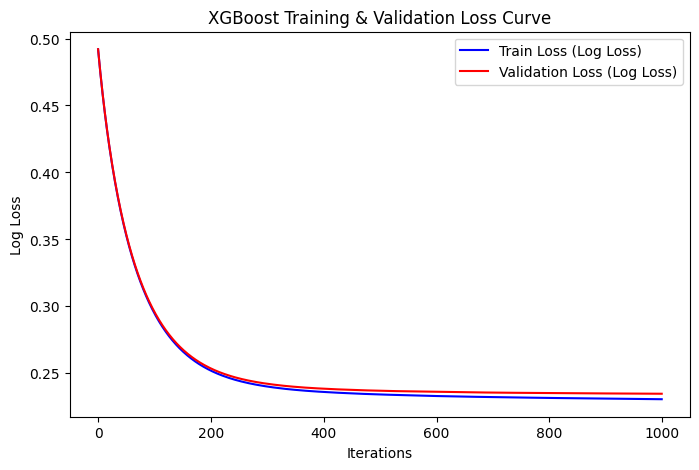

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93    299557
           1       0.66      0.87      0.75     72596

    accuracy                           0.89    372153
   macro avg       0.81      0.88      0.84    372153
weighted avg       0.91      0.89      0.89    372153



In [151]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [152]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[267289  32268]
 [  9758  62838]]

True Positives (TP): 62838
False Positives (FP): 32268
True Negatives (TN): 267289
False Negatives (FN): 9758


### UnderSampling

In [153]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [154]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [155]:
print(f"Train dataset : {data['loan_status'].value_counts()}, \n\nTest dataset : {len(test_data)}")

Train dataset : loan_status
0    1198226
1     290385
Name: count, dtype: int64, 

Test dataset : 372153


In [156]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
data_x_scaled = data_x.copy()

for col in to_scale:
    data_x_scaled[col] = np.log1p(data_x_scaled[col])  # log(1 + x) → 0 값 대응
    X_test[col] = np.log1p(X_test[col])

In [157]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.13, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1295091 samples (87.0%)
Validation size: 193520 samples (13.0%)
Test size: 372153 samples (25.0%)


In [158]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y_train.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1042456
1               252635
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 505270 samples

Undersampling imbalance check
loan_status
0    252635
1    252635
Name: count, dtype: int64


In [159]:
X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y_train = data_under[['loan_status']]  # Target (타겟 변수)

In [160]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
y_train_0 = y_train[y_train['loan_status']==0]
y_train_1 = y_train[y_train['loan_status']==1]
print(f"Train dataset Ratio of: (Fully Paid) / Default  : {len(y_train_0)/len(y_train_1)}")

# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
y_val_0 = y_val[y_val['loan_status']==0]
y_val_1 = y_val[y_val['loan_status']==1]
print(f"Train dataset Ratio of: (Fully Paid) / Default  : {len(y_val_0)/len(y_val_1)}")

Train dataset Ratio of: (Fully Paid) / Default  : 1.0
Train dataset Ratio of: (Fully Paid) / Default  : 4.126357615894039


In [161]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68689	validation_1-logloss:0.68690
[1]	validation_0-logloss:0.68076	validation_1-logloss:0.68078
[2]	validation_0-logloss:0.67475	validation_1-logloss:0.67478
[3]	validation_0-logloss:0.66885	validation_1-logloss:0.66890
[4]	validation_0-logloss:0.66308	validation_1-logloss:0.66314
[5]	validation_0-logloss:0.65741	validation_1-logloss:0.65749
[6]	validation_0-logloss:0.65185	validation_1-logloss:0.65195
[7]	validation_0-logloss:0.64639	validation_1-logloss:0.64652
[8]	validation_0-logloss:0.64104	validation_1-logloss:0.64119
[9]	validation_0-logloss:0.63579	validation_1-logloss:0.63596
[10]	validation_0-logloss:0.63063	validation_1-logloss:0.63083
[11]	validation_0-logloss:0.62557	validation_1-logloss:0.62580
[12]	validation_0-logloss:0.62061	validation_1-logloss:0.62087
[13]	validation_0-logloss:0.61573	validation_1-logloss:0.61602
[14]	validation_0-logloss:0.61094	validation_1-logloss:0.61127
[15]	validation_0-logloss:0.60623	validation_1-logloss:0.60660
[1

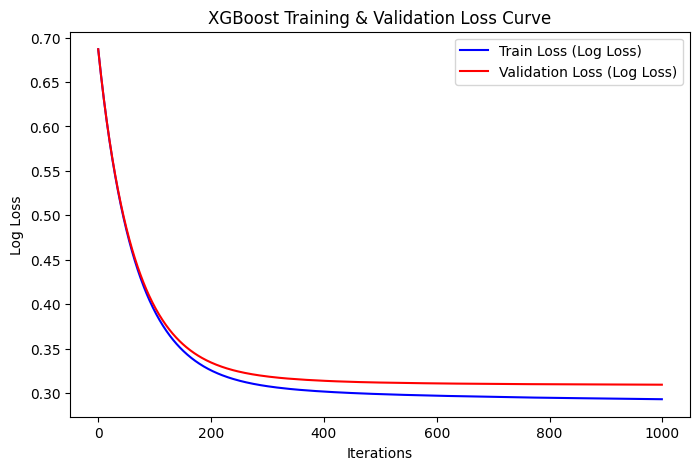

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    299557
           1       0.54      0.94      0.69     72596

    accuracy                           0.83    372153
   macro avg       0.76      0.88      0.79    372153
weighted avg       0.90      0.83      0.85    372153



In [162]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [163]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[242004  57553]
 [  4194  68402]]

True Positives (TP): 68402
False Positives (FP): 57553
True Negatives (TN): 242004
False Negatives (FN): 4194


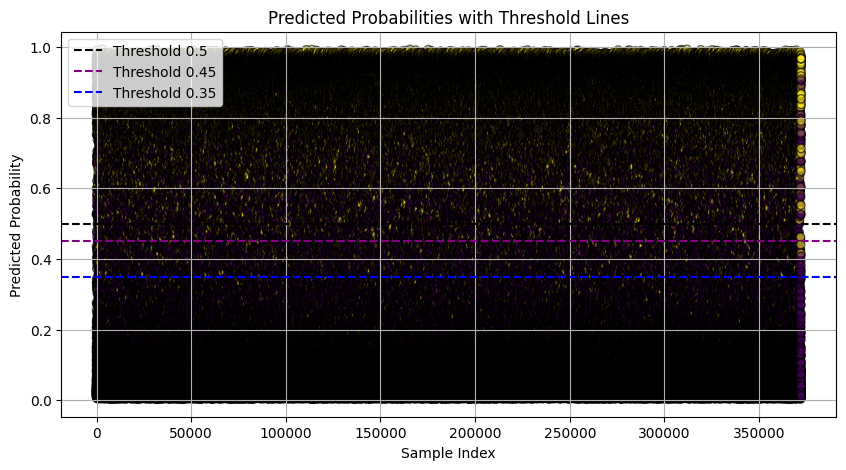

In [164]:
# 확률 vs 클래스 시각화 (2D Scatter)
y_test_1d = y_test.iloc[:, 0] if isinstance(y_test, pd.DataFrame) else y_test

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_prob)), y_prob, c=y_test_1d, alpha=0.6, edgecolors='k')
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.axhline(y=0.45, color='purple', linestyle='--', label='Threshold 0.45')
plt.axhline(y=0.35, color='blue', linestyle='--', label='Threshold 0.35')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities with Threshold Lines')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()


## Oversampling

In [165]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

In [166]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [167]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
data_x_scaled = data_x.copy()

for col in to_scale:
    data_x_scaled[col] = np.log1p(data_x_scaled[col])  # log(1 + x) → 0 값 대응

In [168]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [169]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# 오버샘플링 수행
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 결과 확인
print(f"✅ SMOTE 적용 완료")
print(f"📦 X_train_smote shape: {X_train_smote.shape}")
print(y_train_smote.value_counts())

## 증강 시간이 오래 걸리기 때문 데이터 저장을 한다.
augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)

✅ SMOTE 적용 완료
📦 X_train_smote shape: (1605622, 15)
loan_status
0              802811
1              802811
Name: count, dtype: int64


In [170]:
X_train = augmentation_data.drop(columns='loan_status')
y_train = augmentation_data[['loan_status']]

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.68672	validation_1-logloss:0.68680
[1]	validation_0-logloss:0.68042	validation_1-logloss:0.68058
[2]	validation_0-logloss:0.67423	validation_1-logloss:0.67448
[3]	validation_0-logloss:0.66815	validation_1-logloss:0.66849
[4]	validation_0-logloss:0.66221	validation_1-logloss:0.66263
[5]	validation_0-logloss:0.65638	validation_1-logloss:0.65689
[6]	validation_0-logloss:0.65066	validation_1-logloss:0.65126
[7]	validation_0-logloss:0.64505	validation_1-logloss:0.64573
[8]	validation_0-logloss:0.63954	validation_1-logloss:0.64031
[9]	validation_0-logloss:0.63412	validation_1-logloss:0.63498
[10]	validation_0-logloss:0.62881	validation_1-logloss:0.62977
[11]	validation_0-logloss:0.62359	validation_1-logloss:0.62464
[12]	validation_0-logloss:0.61845	validation_1-logloss:0.61961
[13]	validation_0-logloss:0.61344	validation_1-logloss:0.61468
[14]	validation_0-logloss:0.60851	validation_1-logloss:0.60984
[15]	validation_0-logloss:0.60365	validation_1-logloss:0.60508
[1

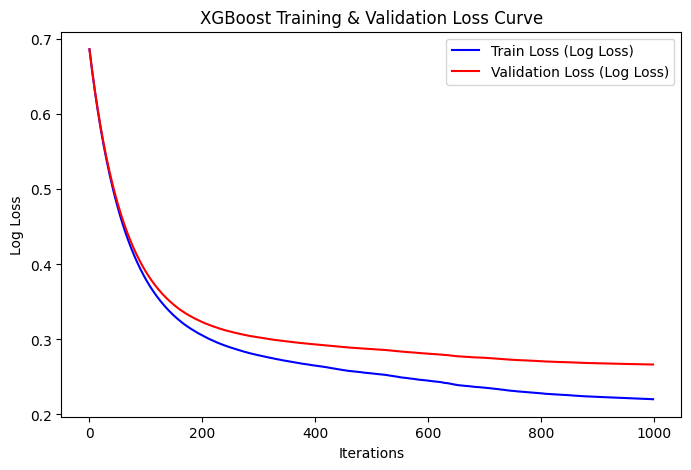

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    299557
           1       0.60      0.91      0.72     72596

    accuracy                           0.86    372153
   macro avg       0.79      0.88      0.82    372153
weighted avg       0.90      0.86      0.87    372153



In [172]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [173]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[254745  44812]
 [  6284  66312]]

True Positives (TP): 66312
False Positives (FP): 44812
True Negatives (TN): 254745
False Negatives (FN): 6284


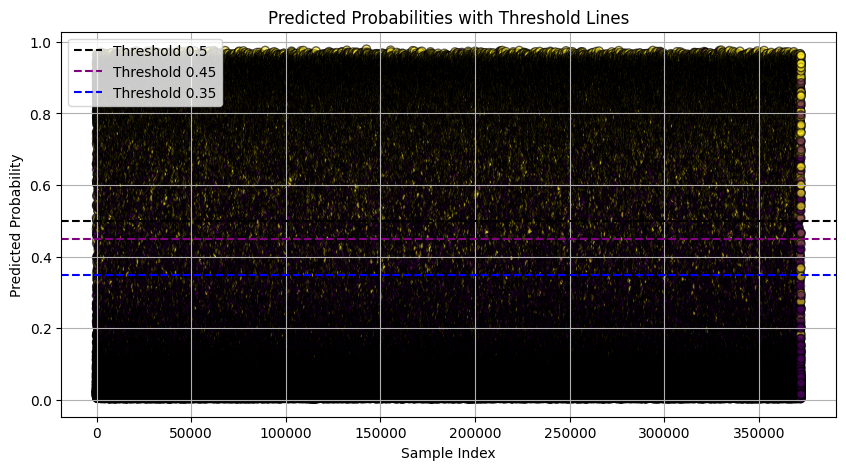

In [174]:
# 확률 vs 클래스 시각화 (2D Scatter)
y_test_1d = y_test.iloc[:, 0] if isinstance(y_test, pd.DataFrame) else y_test

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(y_prob)), y_prob, c=y_test_1d, alpha=0.6, edgecolors='k')
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.axhline(y=0.45, color='purple', linestyle='--', label='Threshold 0.45')
plt.axhline(y=0.35, color='blue', linestyle='--', label='Threshold 0.35')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities with Threshold Lines')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()


## Tablegan

In [175]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

In [176]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [177]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
data_x_scaled = data_x.copy()

for col in to_scale:
    data_x_scaled[col] = np.log1p(data_x_scaled[col])  # log(1 + x) → 0 값 대응

In [178]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x_scaled, data_y, test_size=0.33, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 997369 samples (67.0%)
Validation size: 491242 samples (33.0%)
Test size: 372153 samples (25.0%)


In [179]:
train_dataset = pd.concat([X_train, y_train], axis=1)

fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/train/train_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

X_fake = fake.drop(columns='loan_status')
y_fake = fake[['loan_status']]

In [180]:
"""to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']

scaler_2 = StandardScaler()
X_fake_scaled = X_fake.copy()
X_fake_scaled[to_scale] = scaler.fit_transform(X_fake_scaled[to_scale])"""

"to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']\n\nscaler_2 = StandardScaler()\nX_fake_scaled = X_fake.copy()\nX_fake_scaled[to_scale] = scaler.fit_transform(X_fake_scaled[to_scale])"

In [181]:
to_scale = ['annual_inc', 'total_rev_hi_lim', 'avg_cur_bal', 'revol_bal', 'installment', 'bc_open_to_buy']
X_fake_scaled = X_fake.copy()

for col in to_scale:
    X_fake_scaled[col] = np.log1p(X_fake_scaled[col])  # log(1 + x) → 0 값 대응

In [182]:
fake = pd.concat([X_fake_scaled, y_fake], axis= 1)

In [183]:
from sklearn.utils import shuffle

train_total = pd.concat([train_dataset,fake])
train_total = shuffle(train_total, random_state=42)

In [184]:
X_train = train_total.drop(columns='loan_status')
y_train = train_total[['loan_status']]

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.67405	validation_1-logloss:0.79008
[1]	validation_0-logloss:0.66697	validation_1-logloss:0.78167
[2]	validation_0-logloss:0.66003	validation_1-logloss:0.77346
[3]	validation_0-logloss:0.65324	validation_1-logloss:0.76543
[4]	validation_0-logloss:0.64658	validation_1-logloss:0.75759
[5]	validation_0-logloss:0.64006	validation_1-logloss:0.74992
[6]	validation_0-logloss:0.63366	validation_1-logloss:0.74242
[7]	validation_0-logloss:0.62739	validation_1-logloss:0.73509
[8]	validation_0-logloss:0.62124	validation_1-logloss:0.72791
[9]	validation_0-logloss:0.61520	validation_1-logloss:0.72089
[10]	validation_0-logloss:0.60928	validation_1-logloss:0.71401
[11]	validation_0-logloss:0.60347	validation_1-logloss:0.70728
[12]	validation_0-logloss:0.59777	validation_1-logloss:0.70070
[13]	validation_0-logloss:0.59218	validation_1-logloss:0.69424
[14]	validation_0-logloss:0.58669	validation_1-logloss:0.68792
[15]	validation_0-logloss:0.58129	validation_1-logloss:0.68172
[1

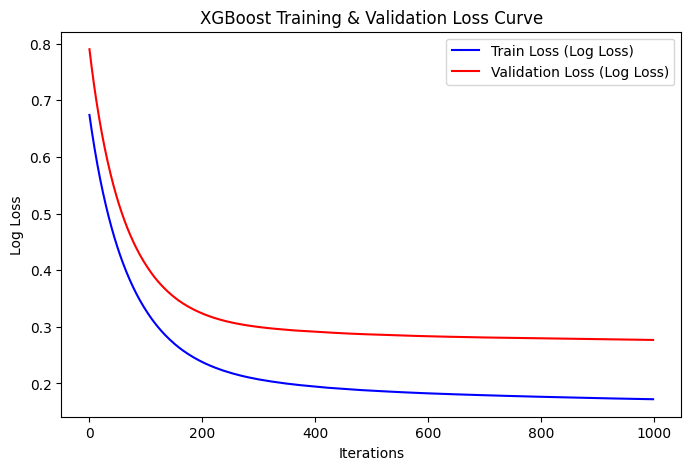

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    299557
           1       0.60      0.89      0.72     72596

    accuracy                           0.87    372153
   macro avg       0.79      0.88      0.82    372153
weighted avg       0.90      0.87      0.87    372153



In [186]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [187]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[257216  42341]
 [  7876  64720]]

True Positives (TP): 64720
False Positives (FP): 42341
True Negatives (TN): 257216
False Negatives (FN): 7876
